---
title: Judicial Decisions on Patent Validity
subtitle: Multilevel multinomial regression models for outcome variability
format: 
    html:
        toc: true
        code-fold: false
        embed-resources: true
jupyter: julia-1.8
---

# Setup

This document provides an overview over modeling efforts in the study of judicial decisions at the German Federal Patent Court.

In contrast to earlier efforts which conflated partially annulled and annulled result categories for modeling convenience, the models presented here utilize a multinomial model architecture, as distinguishing partially and fully annulled decisions is likely important.

In [1]:
using Model
using Dictionaries, SplitApplyCombine
using Distributions
using LogExpFunctions: softmax
using FillArrays
using LinearAlgebra
using TransformVariables
using StructArrays
using CairoMakie

In [2]:
decisions = loaddata("../../../data/processed/json_augmented");

## Multinomial model for aggregated counts

The first model we specify is a simple multinomial model for counts of the respective outcome labels aggregated by groups (e.g., senates) to investigate simple group-level differences:

$$
\begin{align}
y_g &\sim \textrm{Multinomial}(n_g, p_g) \\
p_g &\sim \textrm{MvNormal}(\textbf{0}, \textbf{I})
\end{align}
$$

In [3]:
struct MultinomialGroupsModel{T} <: Model.AbstractDecisionModel
    ys::Vector{Vector{Int}}
    ns::Vector{Int}
    group::Vector{T}
end

function MultinomialGroupsModel(decisions::Vector{Decision}; groupfun)
    gr = group(groupfun, label ∘ outcome, decisions)
    ys = map(gr) do g
        outcomes = ["annulled", "claim dismissed", "partially annulled"]
        [count(==(outcome), g) for outcome in outcomes]
    end |> sortkeys
    ns = map(sum, ys)
    MultinomialGroupsModel(collect(ys), collect(ns), collect(keys(ns)))
end;

In [4]:
function (problem::MultinomialGroupsModel)(θ)
    (; αs) = θ
    (; ys, ns, group) = problem
    nlabels = length(first(ys))

    loglik = sum(zip(ns, ys, eachcol(αs))) do (n, y, p)
        logpdf(Multinomial(n, softmax(p)), y)
    end

    logpri = sum(eachcol(αs)) do p
        logpdf(MvNormal(Zeros(nlabels), I), p)
    end

    loglik + logpri
end

function Model.transformation(problem::MultinomialGroupsModel)
    ngroups = length(problem.group)
    nlabels = length(first(problem.ys))
    as((αs=as(Array, (nlabels, ngroups)),))
end

function predict(problem::MultinomialGroupsModel, post)
    grouplabels = Tuple(Symbol.(problem.group))
    res = map(post) do s
        ps = softmax.(eachcol(s.αs))
        NamedTuple{grouplabels}(ps)
    end
    StructArray(res)
end;

## Variation by Senate

In a first step, we investigate variation between the 7 senates (boards) in the dataset. With the model architecture specified above, each senate get its own vector of coefficients specifying the likelihood of each outcome.

In [5]:
problem = MultinomialGroupsModel(decisions; groupfun = label ∘ senate);

In [7]:
post = Model.sample(problem, 1000, 2)

DynamicHMCPosterior with 2000 samples and parameters (:αs,)

In [21]:
ess, rhat, treestats = Model.checkconvergence(post)
treestats

Hamiltonian Monte Carlo sample of length 2000
  acceptance rate mean: 0.89, 5/25/50/75/95%: 0.68 0.84 0.92 0.97 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 2%, 4 => 8%, 5 => 46%, 6 => 45%

In [9]:
pred = predict(problem, post);

In [27]:
#| code-fold: true

function plot_group!(ax, mat, pos; offset=0.2)
    offsets = [-offset, 0.0, +offset]
    colors = Makie.wong_colors()[1:3]
    for (i, row) in enumerate(eachrow(mat))
        scatter!(ax, row, fill(pos + offsets[i], length(row)); color=(colors[i], .01))
        scatter!(ax, mean(row), pos + offsets[i]; color=colors[i])
        rangebars!(ax, pos + offsets[i], [quantile(row, (.025, .975))]; direction=:x, color=colors[i])
    end
end

function plot_groups(problem, post, groups)
    pred = predict(problem, post)

    fig = Figure(resolution=(600, 800))
    ax = Axis(fig[1,1])

    for (i, group) in enumerate(groups)
        mat = hcat(getproperty(pred, Symbol(group))...)
        plot_group!(ax, mat, i)
    end
    
    ax.yticks = (eachindex(groups), groups)

    colors = Makie.wong_colors()[1:3]
    markers = [MarkerElement(color=c, marker=:circle) for c in colors]
    labels = ["annulled", "claim dismissed", "partially annulled"]
    Legend(fig[2, 1], markers, labels; tellwidth=false, tellheight=true, orientation=:horizontal)

    fig
end;

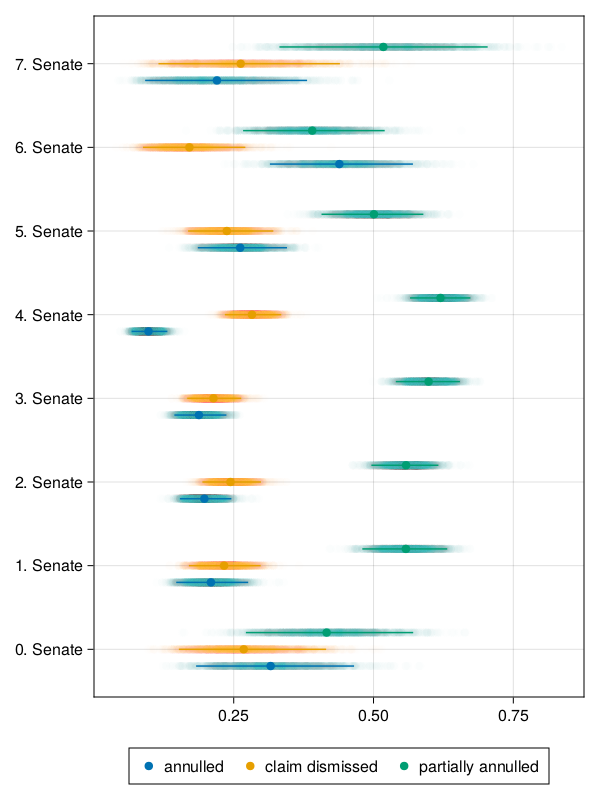

In [29]:
plot_groups(problem, post, problem.group)

In [53]:
#| code-fold: true

function compute_pairwise(pred, g1, g2; outcome)
    p1 = getproperty(pred, g1)
    p2 = getproperty(pred, g2)
    getindex.(p1, outcome) .- getindex.(p2, outcome)
end

function plot_pairwise!(ax, pred, g1, g2; outcome=1, kwargs...)
    diff = compute_pairwise(pred, g1, g2; outcome)
    density!(ax, diff; kwargs...)
    vlines!(ax, 0; color=:black)
end

function plot_pairwise(pred, groups; outcome=1)
    k = length(groups)
    fig = Figure(resolution=(900, 800))

    plotargs = (;color=:grey70, strokewidth=1)

    for i in 1:k 
        for j in 1:k
            i < j && continue
            ax = Axis(fig[i,j]; 
                    yticklabelsvisible=false, yticksvisible=false, xticklabelsize=12, titlesize=12,
                    xgridvisible=false, ygridvisible=false)

            if i == j
                ax.title = groups[i]
                p = getindex.(getproperty(pred, Symbol(groups[i])), outcome)
                density!(ax, p; plotargs...)
                #xlims!(ax, 0, .5)
            else
                ax.title = "$(groups[i]) - $(groups[j])"
                #xlims!(ax, -.3, .3)
                plot_pairwise!(ax, pred, Symbol(groups[i]), Symbol(groups[j]); outcome=outcome, plotargs...)
            end
        end
    end

    outcomes = ["annullment", "dismissal", "partial annullment"]

    Label(fig[0,:], "Pairwise difference in estimated $(outcomes[outcome]) rate"; fontsize=20, font=:bold, halign=:left)

    fig
end;

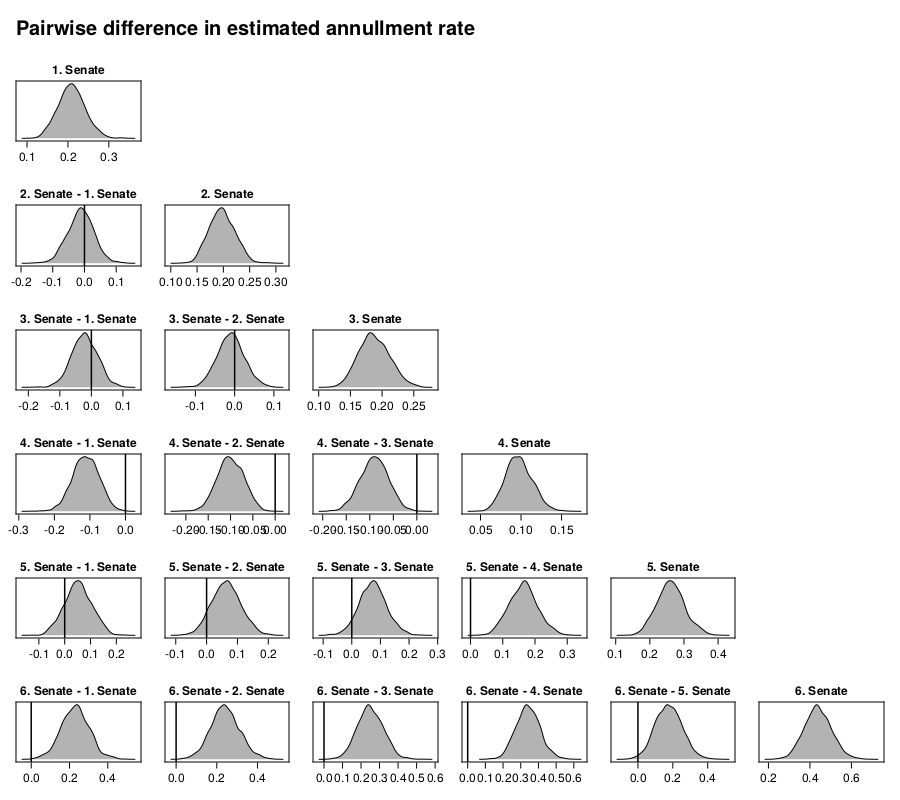

In [54]:
plot_pairwise(pred, problem.group[2:7]; outcome=1)

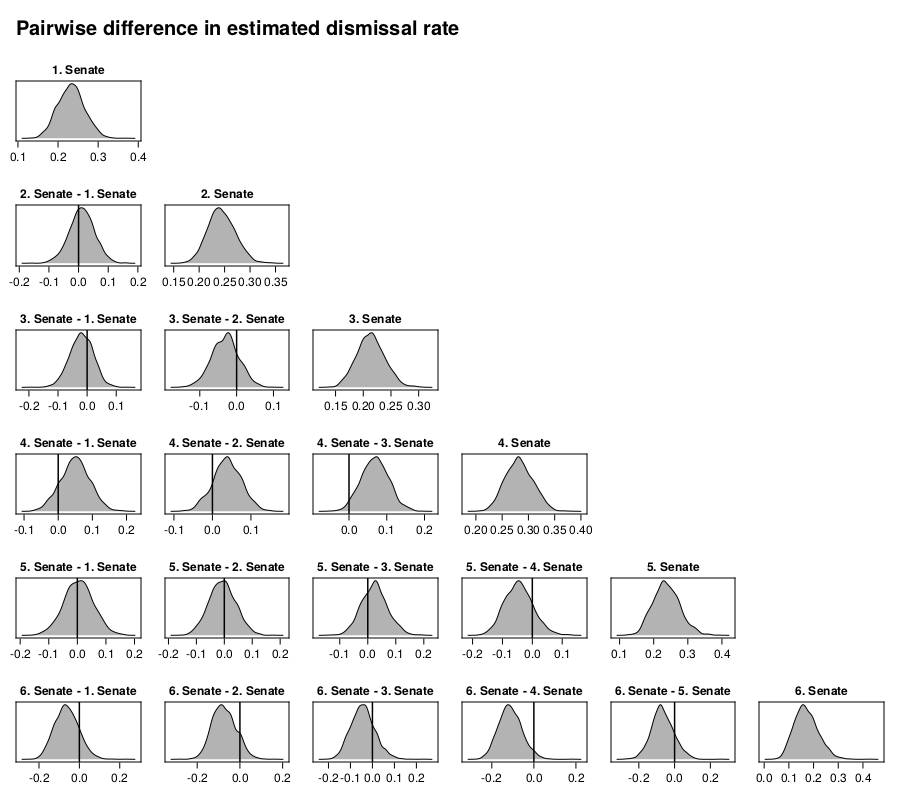

In [55]:
plot_pairwise(pred, problem.group[2:7]; outcome=2)

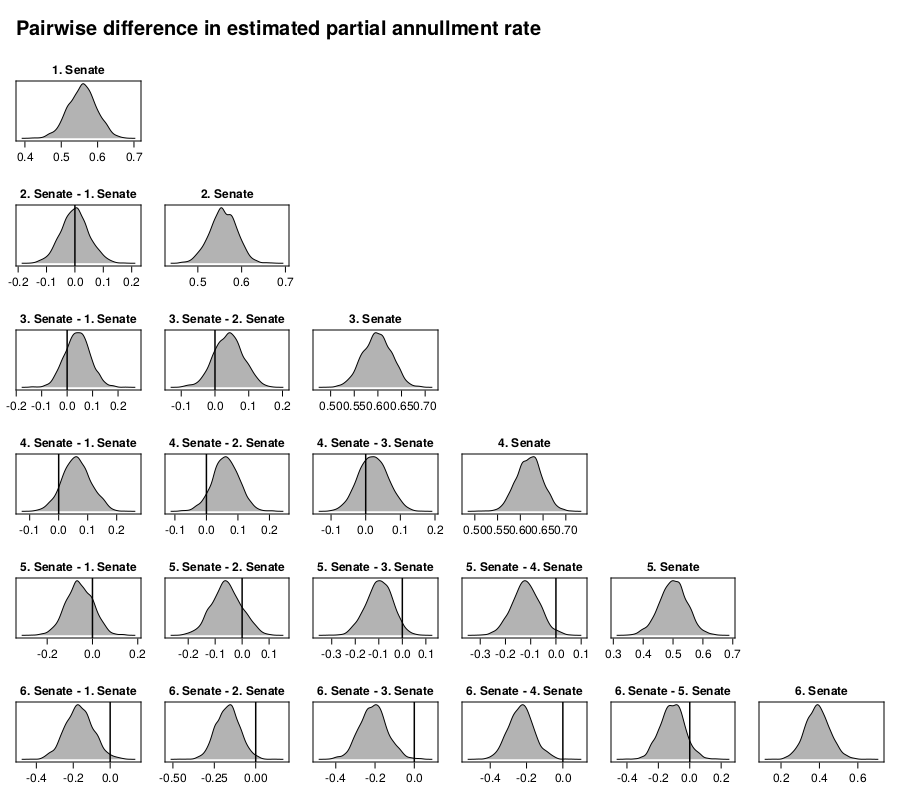

In [56]:
plot_pairwise(pred, problem.group[2:7]; outcome=3)

## Variation by chairman

We now perform the same analysis as before but instead of grouping outcomes by senate, we group them by chairman to investigate differences between judges.

In [52]:
problem_chairman = MultinomialGroupsModel(decisions; groupfun=label ∘ first ∘ judges);

In [17]:
post_chairman = Model.sample(problem_chairman, 1000, 2)

DynamicHMCPosterior with 2000 samples and parameters (:αs,)

In [18]:
Model.checkconvergence(post_chairman)[3]

Hamiltonian Monte Carlo sample of length 2000
  acceptance rate mean: 0.86, 5/25/50/75/95%: 0.62 0.79 0.89 0.96 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 7%, 5 => 93%

In [19]:
pred_chairman = predict(problem_chairman, post_chairman);

In [38]:
selected_judges = problem_chairman.group[problem_chairman.ns .>= 50];

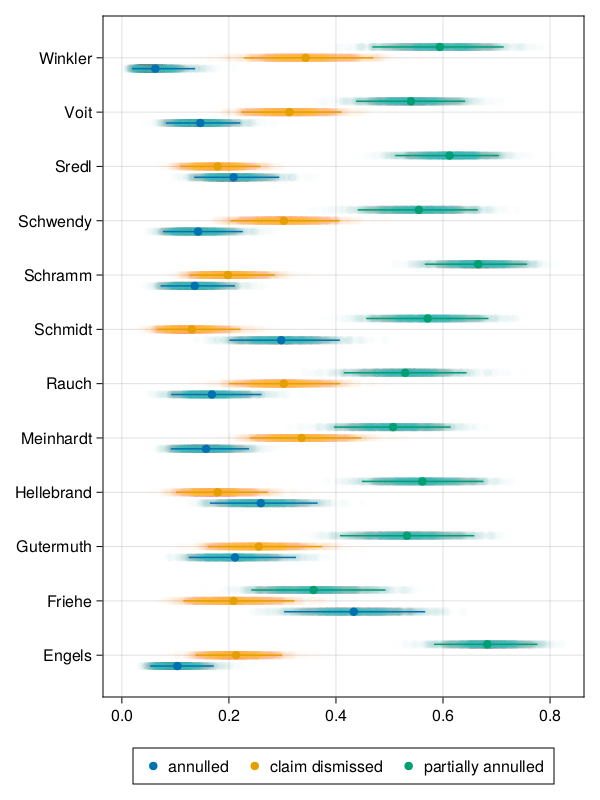

In [39]:
plot_groups(problem_chairman, post_chairman, selected_judges)

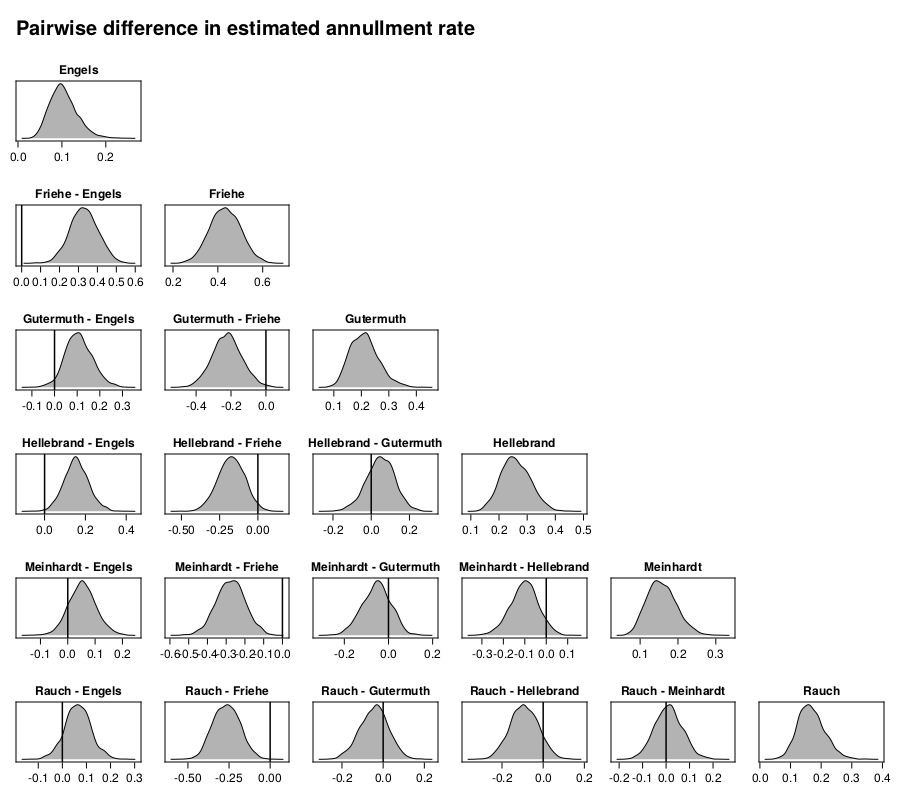

In [57]:
plot_pairwise(pred_chairman, selected_judges[1:6]; outcome=1)

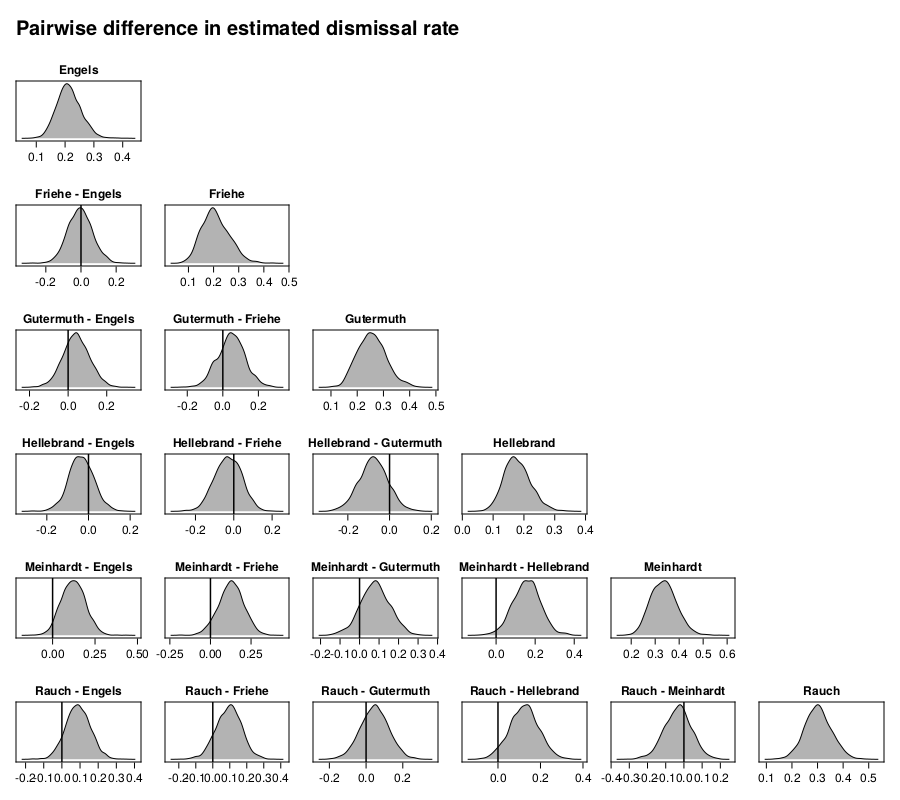

In [58]:
plot_pairwise(pred_chairman, selected_judges[1:6]; outcome=2)